## Predicting Crashes in Financial Markets - Logistic Regression
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Logistic Regression
- Number of features: 16 (mean price change and volatility for different windows over past 252 days)
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1:yes)
- Crash definition: Drawdown in 99.5% quantile

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data import DataLoader

In [2]:
# -------------------- data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_2 import DataLoader
os.chdir('/home/roman/Documents/Projects/Bubbles/data')

datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.091, -0.109, -0.120, -0.144, -0.166, -0.110, -0.233]
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)

months = 3              # <-- predict if crash n months ahead
select_features = True # <-- if True: 8 time windows for mean price change and vol year
sequence = None           # <-- number of days lookback as input(only if select_features=False)
vol = False             # <-- if True: include 10 day volatility for each day in sequence
test_data = 'N225'      # <-- select dataset for testing
dfs_xy = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, crashes=crashes, \
                        select_features=select_features, vol=vol)

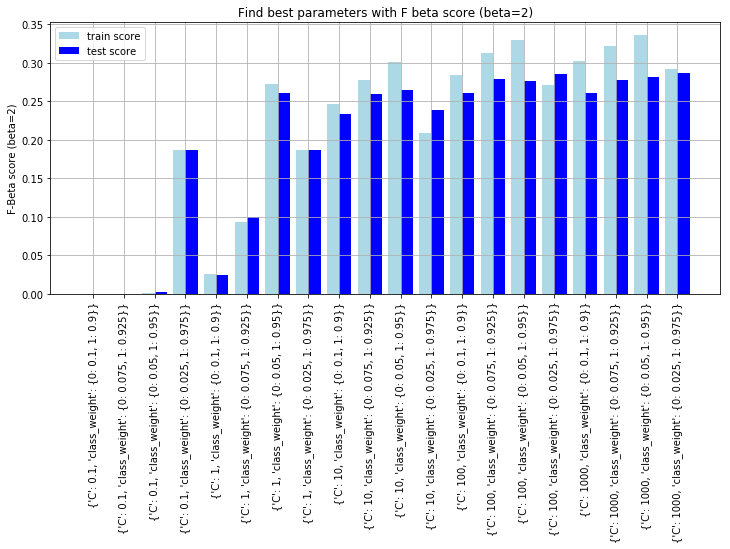

In [9]:
# -------------------- Find best parameters with grid search -------------------- #
model_name = 'Logistic Regression'
beta = 2
# Find parameters with grid search:
fbeta_scorer = make_scorer(fbeta_score, beta=beta)
#param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.05, 1:.95}, {0:.04, 1:.96}, \
#                {0:.03, 1:.97}, {0:.025, 1:.975}, {0:.02, 1:.98}]}]   # <-- 1 month
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.1, 1:.9}, {0:.075, 1:.925}, \
               {0:.05, 1:.95}, {0:.025, 1:.975}]}]   # <-- 3 months
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.11, 1:.89}, {0:.1, 1:.9}, \
#                {0:.09, 1:.91}, {0:.08, 1:.92}]}]   # <-- 6 months
clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, scoring=fbeta_scorer)
np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=test_data)
x_tr = np_train[:, 0:-1]
y_tr = np_train[:, -1].astype(int)  
model = clf.fit(x_tr, y_tr)
labels = model.cv_results_['params']
tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']

# Plot grid search results:
rcParams['figure.figsize'] = 12, 5
plt.bar(x=np.arange(len(tr_score))-0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score))+0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-Beta score (beta=2)')
plt.legend()
plt.grid()
plt.show()

In [11]:
# -------------------- Train Logistic Regression -------------------- #
clf = linear_model.LogisticRegression(C=1000, class_weight={0:.075, 1:.925})
y_train_all = []
y_test_all = []
y_pred_tr_all = []
y_pred_t_all = []
for test_data in dataset_names:
    np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=test_data)
    x_train = np_train[:, 0:-1]
    #x_train = np.expand_dims(x_train, axis=2)
    y_train = np_train[:, -1].astype(int)
    y_train_all.append(y_train)
    x_test = np_test[:, 0:-1]
    #x_test = np.expand_dims(x_test, axis=2)
    y_test = np_test[:, -1].astype(int)
    y_test_all.append(y_test)
    print('Train ' + str(model_name) + ' - test data: ' + str(test_data))
    model = clf.fit(x_train, y_train)
    y_pred_tr = model.predict(x_train)
    y_pred_tr_all.append(y_pred_tr)
    y_pred_t = model.predict(x_test)
    y_pred_t_all.append(y_pred_t)

Train Logistic Regression - test data: S&P 500
Train Logistic Regression - test data: N225
Train Logistic Regression - test data: SSE
Train Logistic Regression - test data: HSI
Train Logistic Regression - test data: BSESN
Train Logistic Regression - test data: SMI
Train Logistic Regression - test data: BVSP


In [15]:
# -------------------- Evaluate results -------------------- #
beta = 2
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_t_bin_all = []
y_pred_tr_bin_all = []
score_fbeta_tr = []
score_fbeta_t = []
for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                y_pred_tr_all, y_pred_t_all):
    #y_pred_tr_bin = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
    y_pred_tr_bin = y_pred_tr.astype(int)
    y_pred_tr_bin_all.append(y_pred_tr_bin)
    precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
    recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
    accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
    score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
    #y_pred_t_bin = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
    y_pred_t_bin = y_pred_t.astype(int)
    y_pred_t_bin_all.append(y_pred_t_bin)
    precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
    recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
    accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
    score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))

y_tr_pred_pos = [sum(y_pred) / (len(y_pred)) for y_pred in y_pred_tr_bin_all]
y_t_pred_pos = [sum(y_pred) / (len(y_pred)) for y_pred in y_pred_t_bin_all]
d = {'precision_tr': np.round(precision_tr,2), \
     'recall_tr': np.round(recall_tr,2), 'accuracy_tr': np.round(accuracy_tr,2), \
     'score_fbeta_tr': np.round(score_fbeta_tr,2), \
     'precision_t': np.round(precision_t,2), \
     'recall_t': np.round(recall_t,2), 'accuracy_t': np.round(accuracy_t,2), \
     'score_fbeta_t': np.round(score_fbeta_t,2)}
results = pd.DataFrame.from_dict(d, orient='index')
results.columns = dataset_names
print('Results (for each train/test splits) -' + model_name + ':')
print(results)
print('\n')

# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
avg_score_fbeta_tr = sum(score_fbeta_tr) / len(score_fbeta_tr)
avg_score_fbeta_t = sum(score_fbeta_t) / len(score_fbeta_t)

# calculate precision, recall, accuracy for comparable random model
sum_tr = 0
sum_t = 0
pos_tr = 0
pos_t = 0
sum_tr_pred = 0
sum_t_pred = 0
pos_tr_pred = 0
pos_t_pred = 0
for y_tr, y_t, y_tr_pr, y_t_pr in zip(y_train_all, y_test_all, y_pred_tr_bin_all, \
                y_pred_tr_bin_all):
    sum_tr += len(y_tr)
    pos_tr += sum(y_tr)
    sum_t += len(y_t)
    pos_t += sum(y_t)
    sum_tr_pred += len(y_tr_pr)
    sum_t_pred += len(y_tr_pr)
    pos_tr_pred += sum(y_t_pr)#[0]
    pos_t_pred += sum(y_t_pr)#[0]
y_train_pos_actual = pos_tr / sum_tr
y_train_pos_pred = pos_tr_pred / sum_tr_pred
rnd_TP = y_train_pos_pred * y_train_pos_actual
rnd_FP = y_train_pos_pred * (1 - y_train_pos_actual)
rnd_TN = (1 - y_train_pos_pred) * (1 - y_train_pos_actual)
rnd_FN = (1 - y_train_pos_pred) * y_train_pos_actual
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
y_test_pos_actual = pos_t / sum_t
y_test_pos_pred = pos_t_pred / sum_t_pred
rnd_TP = y_test_pos_pred * y_test_pos_actual
rnd_FP = y_test_pos_pred * (1 - y_test_pos_actual)
rnd_TN = (1 - y_test_pos_pred) * (1 - y_test_pos_actual)
rnd_FN = (1 - y_test_pos_pred) * y_test_pos_actual
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results (average over all train/test splits) -' + model_name + ':')
print('Number of features: ' + str(sequence) + '; number of rows: ' \
      + str(sum_tr + sum_t))
print('Positive train cases actual:        '+ str(round(y_train_pos_actual, 2)))
print('Positive train cases predicted:     '+ str(round(y_train_pos_pred, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(avg_score_fbeta_tr, 2)))
print('Positive test cases actual:         '+ str(round(y_test_pos_actual, 2)))
print('Positive test cases predicted:      '+ str(round(y_test_pos_pred, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(avg_score_fbeta_t, 2)))

Results (for each train/test splits) -Logistic Regression:
                S&P 500  N225   SSE   HSI  BSESN   SMI  BVSP
precision_tr       0.15  0.17  0.14  0.15   0.15  0.15  0.14
recall_tr          0.35  0.40  0.33  0.35   0.35  0.35  0.33
accuracy_tr        0.88  0.89  0.88  0.88   0.88  0.89  0.88
score_fbeta_tr     0.28  0.32  0.26  0.28   0.28  0.28  0.26
precision_t        0.32  0.08  0.19  0.11   0.11  0.18  0.11
recall_t           0.19  0.16  0.68  0.45   0.35  0.21  0.81
accuracy_t         0.95  0.87  0.85  0.84   0.86  0.90  0.70
score_fbeta_t      0.20  0.13  0.44  0.28   0.24  0.21  0.35


Results (average over all train/test splits) -Logistic Regression:
Number of features: None; number of rows: 417851
Positive train cases actual:        0.04
Positive train cases predicted:     0.11
Avg precision train (model/random): 0.15 / 0.04
Avg recall train (model/random):    0.35 / 0.11
Avg accuracy train (model/random):  0.88 / 0.86
Score train fbeta:                  0.28
Positiv

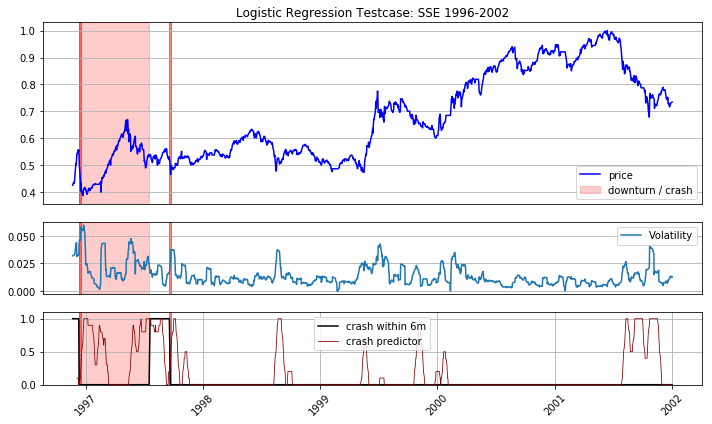

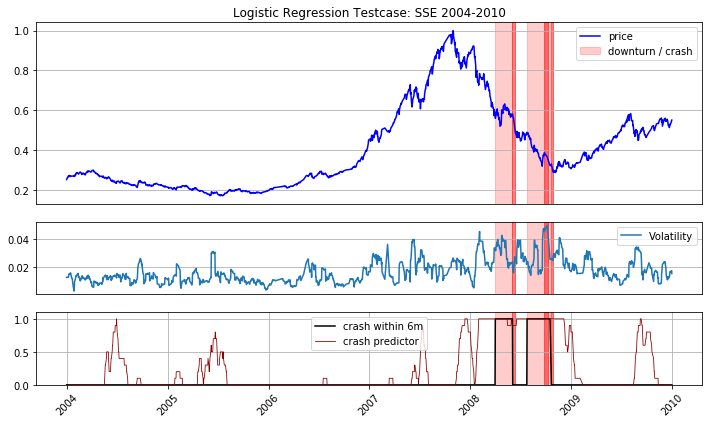

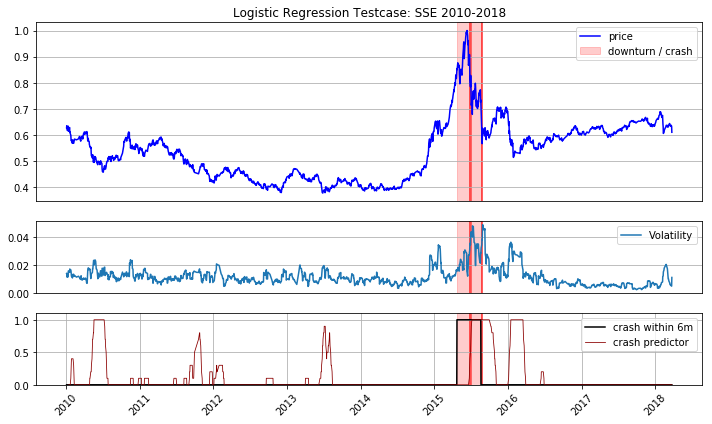

In [16]:
# -------------------- Plot results -------------------- #
test_data = 'SSE'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2002-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d'), df.index[-1]]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  